## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [156]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [157]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


b. Use the cell below to find the number of rows in the dataset.

In [159]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [160]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [161]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [162]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group != "treatment" and landing_page == "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [163]:
df.isnull().count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [164]:
df2 = df.drop((((df.query('group != "treatment" and landing_page == "new_page"')).index) | ((df.query('group == "treatment" and landing_page != "new_page"')).index)))

In [165]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [166]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [167]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [168]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [169]:
df.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [170]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

In [171]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [172]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [173]:
df2.query('group == "control" and converted == 1').shape[0] / df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [174]:
df2.query('group == "treatment" and converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [175]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer**<br>
There is no sufficient evidence that the new treatment page leads to more conversions since the results in `b` and `c` above are nearly the same, so we can't be conclusive that the new treatment page is better. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, I will consider that I need to make the decision just based on all the data provided.  I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

**Answer** <br>
- **$H_{0}$**: **$p_{old}$** $\geqslant$ **$p_{new}$**<br>
- **$H_{1}$**: **$p_{old}$** $<$ **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [176]:
p_new = df2.query('converted == 1').shape[0] / df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [177]:
p_old = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [178]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [179]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [180]:
new_page_converted = np.random.choice([0,1], size=n_new, p=(1-p_new, p_new))

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [181]:
old_page_converted = np.random.choice([0,1], size=n_old, p=(1-p_old, p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [182]:
new_page_converted.mean() - old_page_converted.mean()


-0.0010963363195080622

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [183]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=(1-p_new, p_new))
    old_page_converted = np.random.choice([0,1], size=n_old, p=(1-p_old, p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    

In [184]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

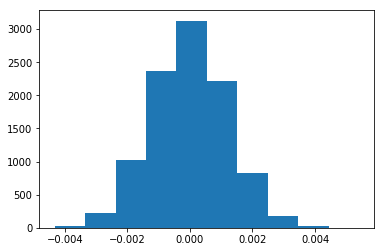

In [185]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [186]:
new_p_convert = df2.query('landing_page == "new_page" and converted == 1').shape[0] / n_new
new_p_convert

0.11880806551510564

In [187]:
old_p_convert = df2.query('landing_page == "old_page" and converted == 1').shape[0] / n_old
old_p_convert

0.1203863045004612

In [188]:
observed_diff = new_p_convert - old_p_convert
observed_diff

-0.0015782389853555567

In [189]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.shape[0])

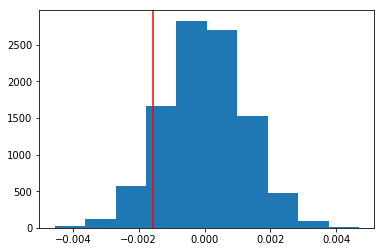

In [190]:
plt.hist(null_vals)
plt.axvline(observed_diff, c = 'r');

In [191]:
p_value = (null_vals > observed_diff).mean()
p_value

0.90580000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**<br>
- It is called P-Value.
- It is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.
- It shows that our evidence is not sufficient enough, so we failed to reject the NULL hypothesis.
- So that the conversions to new page is not statistically significant compared to the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [192]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [193]:
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])

statistic, z_p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')

In [194]:
print('Statistic:', statistic)
print('P-Value:', z_p_value)

Statistic: -1.31092419842
P-Value: 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**<br>
- They agree with my findings above.
- P-Value shows that our evidence is not sufficient enough, so we failed to reject the NULL hypothesis.
- So that the conversions to new page is not statistically significant compared to the old page.
- Z-score gives you an idea of how far from the mean a data point is.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, it is a classification problem and I will use the Logistic Regression algorithm.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [195]:
regression_df = df2.copy()

In [196]:
# Adding Intercept
regression_df['intercept'] = 1

In [197]:
# Adding Dummy Variables
regression_df['ab_page']= pd.get_dummies(df2['group'])['treatment']

In [198]:
regression_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [199]:
logit_model = sm.Logit(regression_df['converted'], regression_df[['intercept', 'ab_page']])
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [200]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-11 10:13 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer**<br>
- **P-Value = 0.1889**
- **$H_{0}$**: **$p_{old}$** $=$ **$p_{new}$**<br>
- **$H_{1}$**: **$p_{old}$** $\neq$ **$p_{new}$**<br>
- This is a two-sided p-value compared to a one-sided p-value in **part ||,** so that is why they differ.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**<br>
- Adding other factor may enhance our classification and also reduce the chance of overfitting.
- But adding new features in an improper manner could increase the complexity of our model. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [201]:
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [202]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [203]:
regression_df2 = country_df.set_index('user_id').join(df2.set_index('user_id'), how='right')
regression_df2.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
851104,US,2017-01-21 22:11:48.556739,control,old_page,0
804228,US,2017-01-12 08:01:45.159739,control,old_page,0
661590,US,2017-01-11 16:55:06.154213,treatment,new_page,0
853541,US,2017-01-08 18:28:03.143765,treatment,new_page,0
864975,US,2017-01-21 01:52:26.210827,control,old_page,1


In [204]:
regression_df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [205]:
regression_df2[['CA','UK','US']] = pd.get_dummies(regression_df2['country'])

In [206]:
regression_df2.drop('CA', axis=1, inplace=True)
regression_df2.head()

,country,timestamp,group,landing_page,converted,UK,US
user_id,,,,,,,
851104,US,2017-01-21 22:11:48.556739,control,old_page,0,0,1
804228,US,2017-01-12 08:01:45.159739,control,old_page,0,0,1
661590,US,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
853541,US,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
864975,US,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [207]:
regression_df2.US.value_counts()

1    203619
0     86965
Name: US, dtype: int64

In [208]:
regression_df2.UK.value_counts()

0    218118
1     72466
Name: UK, dtype: int64

In [209]:
regression_df2['ab_page']= pd.get_dummies(regression_df2['group'])['treatment']
regression_df2['intercept'] = 1

In [210]:
regression_df2.head()

,country,timestamp,group,landing_page,converted,UK,US,ab_page,intercept
user_id,,,,,,,,,
851104,US,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1
804228,US,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,1
661590,US,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,1
853541,US,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,1
864975,US,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1


In [211]:
logit_model2 = sm.Logit(regression_df2['converted'], regression_df2[['intercept', 'ab_page', 'US', 'UK']])
results_2 = logit_model2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [212]:
results_2.summary2(), results.summary2()

(<class 'statsmodels.iolib.summary2.Summary'>
 """
                           Results: Logit
 Model:              Logit            No. Iterations:   6.0000     
 Dependent Variable: converted        Pseudo R-squared: 0.000      
 Date:               2021-08-11 10:13 AIC:              212781.1253
 No. Observations:   290584           BIC:              212823.4439
 Df Model:           3                Log-Likelihood:   -1.0639e+05
 Df Residuals:       290580           LL-Null:          -1.0639e+05
 Converged:          1.0000           Scale:            1.0000     
 -------------------------------------------------------------------
                Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
 -------------------------------------------------------------------
 intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
 ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
 US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
 UK             0

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [213]:
regression_df2['US_page'] = regression_df2['ab_page']* regression_df2['US']
regression_df2['UK_page'] = regression_df2['ab_page']* regression_df2['UK']

In [214]:
regression_df2.head()

,country,timestamp,group,landing_page,converted,UK,US,ab_page,intercept,US_page,UK_page
user_id,,,,,,,,,,,
851104,US,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1,0,0
804228,US,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,1,0,0
661590,US,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,1,1,0
853541,US,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,1,1,0
864975,US,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1,0,0


In [215]:
logit_model3 = sm.Logit(regression_df2['converted'], regression_df2[['intercept', 'ab_page', 'US', 'UK', 'US_page', 'UK_page']])
results_3 = logit_model3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [216]:
results_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-11 10:13 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

<a id='conclusions'></a>
## The End